# Introduction to Deep Learning with PyTorch

In this tutorial we will go through the basics of how to implement a simple Deep Learning model on Python, from the data preprocessing to the final evaluation and model improvements.

To do so, and for most of this notebook, we will work on a __image classification__ task. The goal here is to take raw images as input and have our model predict to which of several categories the image belongs to.

Why Cloud Computing Matters for Generative AI and Machine Learning

Generative AI models, along with most modern machine learning techniques, have several characteristics that make cloud computing a powerful companion:

* **Computational Demands**:  Training complex neural networks, especially those involved in generative AI, requires enormous amounts of processing power. GPUs (Graphical Processing Units), often essential for deep learning acceleration, are readily available and scalable in cloud environments. Cloud providers offer on-demand access to resources that would be prohibitively expensive to provision locally.

* **Data Storage**: Generative AI often works with massive datasets of images, text, or other modalities. Cloud platforms provide scalable and flexible storage solutions, making it easy to manage large training datasets.

* **Collaboration and Accessibility**: Teams of researchers and developers can easily collaborate on model development within shared cloud environments. These same cloud environments make deploying trained models as web services or APIs highly convenient.

This notebook although simple introduces these fundamental aspects of computing.

# Importing libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import sklearn.metrics as metrics
import itertools
from tqdm import tqdm



# Loading the Fashion-MNIST Dataset

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples.


Each image is 28x28 pixels, and the categories include items like T-shirts/tops, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots. The simplicity of the dataset makes it accessible for beginners to experiment with image classification tasks, while its similarity to real-world data challenges makes it useful for more advanced studies in machine learning and computer vision.


The [fashion_mnist](https://github.com/zalandoresearch/fashion-mnist) dataset:

![Fashion MNIST](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)




<br>

Luckily for us, this dataset is available in a convenient format, so let's load it and take a look.

### The basics of data loading for Deep Learning with PyTorch

***Data Preparation in PyTorch: Transformations, Train-Test Splits, and DataLoaders***

When it comes to machine learning and deep learning, preparing your dataset correctly is crucial. This process involves several key steps: applying transformations, splitting the dataset into training and test sets, and efficiently batching the data for processing using DataLoaders. Let's explore these concepts and their significance.

**Transformations**

Transformations are operations applied to data before it is used for training. These steps are essential for preprocessing the data, making it more suitable for training neural networks.


*   **Normalization**: Adjusts the data scale to a mean and standard deviation that are more suitable for the models, often scaling image pixel values to a range like [0, 1] or [-1, 1].
*   **Conversion**: Changes the data type, such as converting images from PIL format to PyTorch tensors, facilitating operations with deep learning models.
*   **Augmentation**: Increases the dataset size artificially by applying various transformations (e.g., rotations, flipping) to existing data, enhancing model robustness. We'll study this in another session.


**Train-Test Sets**

Splitting the dataset into training and test sets is standard practice in machine learning:

* **Training Set**: Used to train the model, allowing it to learn from this data.

* **Test Set**: Used to evaluate the model's performance, providing an unbiased assessment. It's crucial for testing the model's ability to generalize to new, unseen data.

**DataLoader**

The DataLoader class in PyTorch simplifies data loading, offering several features:

* **Batching**: Divides the data into batches, speeding up training and making it feasible to work with large datasets. The batch size is a crucial hyperparameter that determines the number of training examples used in one iteration. It affects memory usage, training speed, and model performance. Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum. Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

* **Shuffling**: Randomizes the data order, reducing overfitting risk by preventing the model from memorizing the data sequence.

* **Parallelism**: Speeds up data loading by using multiple subprocesses.

* **Customization**: Allows for custom data loading logic, such as special batching or sampling strategies.

In [ ]:
# Transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize((0.5,), (0.5,))
     ])

# Loading the dataset
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

test_set = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

# Split the dataset (e.g., 80% for training, 20% for testing)
train_size = int(0.8 * len(train_set))
eval_size = len(train_set) - train_size
train_set, eval_set = torch.utils.data.random_split(train_set, [train_size, eval_size])

BATCH_SIZE = 32

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_set, batch_size=BATCH_SIZE, shuffle=False)


test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 19216629.12it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 343705.69it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6054002.08it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5487236.85it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### For more details about the functions above:

```transforms.Compose```: This is a function from the torchvision library that chains together multiple image transformations. The transformations are applied in the sequence they are provided.

```transforms.ToTensor()```: Converts a PIL Image or a NumPy array into a PyTorch tensor. It changes the shape from HxWxC to CxHxW (Height x Width x Channels to Channels x Height x Width) and scales the image's intensity values from [0, 255] to [0.0, 1.0].

```transforms.Normalize((0.5,), (0.5,))```: Normalizes the tensor with a mean and standard deviation. Since the images are grayscale, a single mean and standard deviation are provided. This normalization shifts the intensity values to have a mean of 0.5 and a standard deviation of 0.5. After applying this normalization, the intensity values will range from -1.0 to 1.0.

```torchvision.datasets.FashionMNIST```: Loads the Fashion-MNIST dataset. This class is part of the torchvision.datasets module. Fashion-MNIST is a dataset of Zalando's article images, intended as a more challenging replacement for the original MNIST dataset.

```root='./data'```: Specifies the directory where the dataset will be stored. If the dataset is not present in this directory, it will be downloaded.

```train=True```: Indicates that the training dataset should be loaded. If set to False, the test dataset would be loaded instead.

```download=True```: If the dataset is not available in the root directory, setting this to True will download it from the internet.

```transform=transform```: Applies the previously defined transformations to each image in the dataset.

```DataLoader```: Wraps the dataset and provides an iterable over the dataset. It supports automatic batching, sampling, shuffling, and multiprocess data loading.

```train_set```: The dataset to load data from.

```batch_size=4``` The number of samples to load in each batch. This means that each iteration over the DataLoader will return a batch of 4 images and their corresponding labels.

```shuffle=True```: Shuffles the dataset at every epoch to reduce model overfitting and improve model generalization.

### Understanding and Visualizing the data

In [ ]:
# Print the first 10 labels
print("First 10 labels:", test_set.targets[:10])

First 10 labels: tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])


**What do these numbers mean?**

According to the [Fashion MNIST Github site](https://github.com/zalandoresearch/fashion-mnist#labels), this is what each number 0-9 corresponds to:

| Label  | Description  |
|---|---|
|  0 | T-shirt/top  |
|  1 |  Trouser |
|  2 |   Pullover |
|  3 |  Dress |
|  4 |  Coat |
|  5 |  Sandal |
|  6 |   Shirt |
|  7 |  Sneaker |
|  8 |   Bag |
|  9 |  Ankle boot |

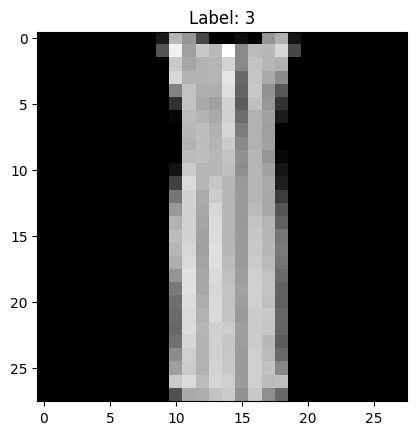

In [ ]:
# Display a raw image

# Get a sample image and its label
sample_image, sample_label = train_set[0]

# Display the image as grayscale
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.title(f"Label: {sample_label}")
plt.show()

In [ ]:
#print(sample_image)

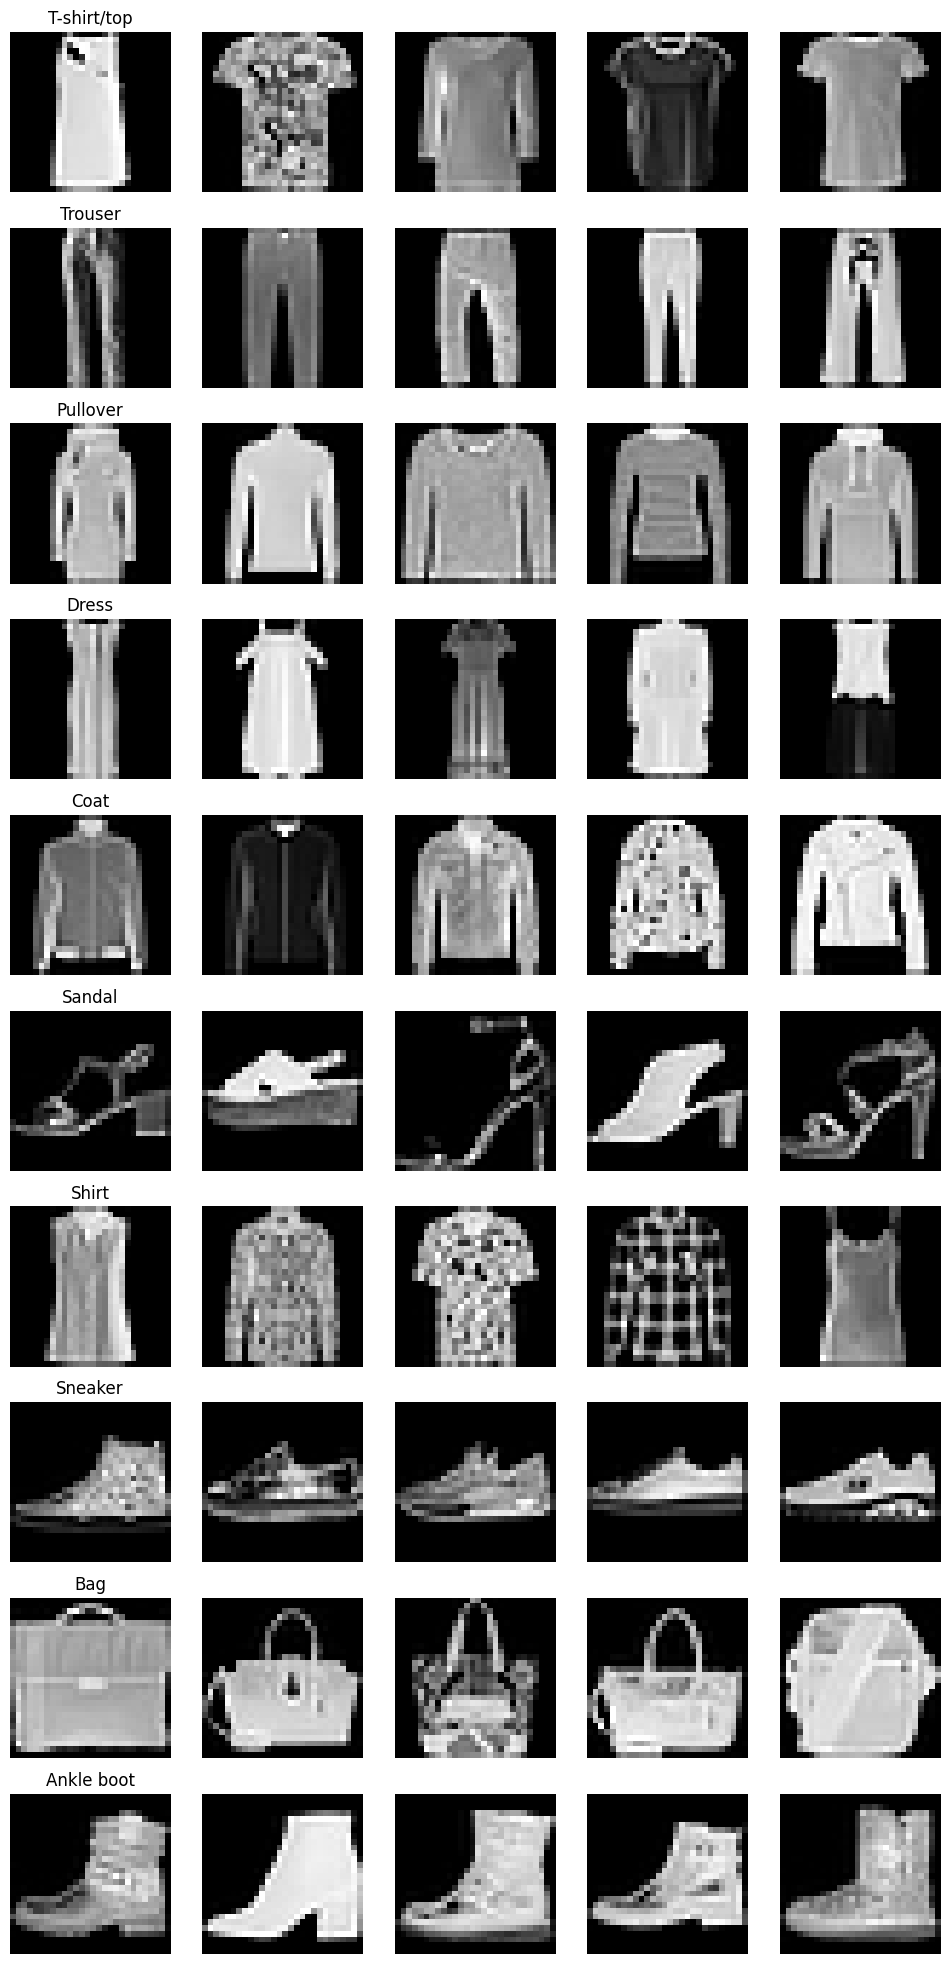

In [ ]:
# Create the label lookup table
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def show_images_by_class(dataset, num_images=5):
    fig, axs = plt.subplots(10, num_images, figsize=(12, 25))
    class_counts = {i: 0 for i in range(10)}

    for image, label in dataset:
        if class_counts[label] < num_images:
            row = label  # Class index determines the row
            col = class_counts[label]  # Column within the row
            axs[row, col].imshow(image.squeeze(), cmap='gray')
            axs[row, col].axis('off')

            # Set title as the class label on the first image of each row
            if col == 0:
                axs[row, col].set_title(classes[label], size='large')

            class_counts[label] += 1

    plt.show()

# Assuming 'train_set' is already loaded with necessary transforms
show_images_by_class(train_set)


# Defining the Neural Network

The first step is to create the neural network architecture.

**PyTorch and ```nn.Module```**: PyTorch is a leading deep learning library prized for its flexibility and dynamic computation graphs. The ```nn.Module``` class is the cornerstone of building neural networks in PyTorch, providing the structure for layers and the forward propagation logic.

**Input and Output**: We're working with images of size 28x28 pixels here. The ```Linear``` layer expects a flat input, hence the ```nn.Flatten``` operation.  The final output has 10 units because we're performing a 10-class classification task.

**Linear Layers ```nn.Linear```**: Linear layers perform basic matrix multiplication and addition (followed by a bias term) to transform the input into a different representational space.

**ReLU Activation ```nn.ReLU```**: The ReLU (Rectified Linear Unit) is a popular non-linear activation function crucial for preventing the vanishing gradient problem in deep networks. It simply sets negative values to zero.

**Sequential ```nn.Sequential```**: PyTorch's ```nn.Sequential``` is a container that helps you chain layers and activation functions neatly.

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()  # Initialize base class (nn.Module)

    self.flatten = nn.Flatten()  # Flattens multidimensional input into a single dimension

    self.linear_relu_stack = nn.Sequential(
      nn.Linear(28*28, 512),  # First linear layer (input: 28*28 pixels, output: 512 nodes)
      nn.ReLU(),               # ReLU activation (introduces non-linearity)
      nn.Linear(512, 10),      # Second linear layer (maps to 10 output classes (trousers, dresses, etc))
    )

  def forward(self, x):
    x = self.flatten(x)            # Flatten the input image data
    logits = self.linear_relu_stack(x)  # Pass through linear layers and activation
    return logits                   # Raw output scores for each class


## Initialize the Network and Define Loss Function and Optimizer

These lines complete the core setup for training your feedforward neural network. You now have:

* A Neural Network (```net```): Contains the structure of your model.
* A Loss Function (```criterion```): Defines how to measure the error of your predictions.
* An Optimizer (```optimizer```): Determines how to update the network's weights to minimize the loss.

In [ ]:
# Create an instance of our neural network model
net = NeuralNet()

# Specify the input shape ([batch_size, 1, 28, 28] for images)
summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                   [-1, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.55
Estimated Total Size (MB): 1.57
----------------------------------------------------------------


In [ ]:
# Define the loss function (cross-entropy is common for classification)
criterion = nn.CrossEntropyLoss()

# Set up the optimizer (SGD (stochastic gradient descent) with a learning rate of 0.001 and momentum)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Details about the code above:

*  `nn.CrossEntropyLoss` is a standard loss function for classification tasks. It gauges the "discrepancy"  between the model's predictions and the true labels.

* **Stochastic Gradient Descent (```SGD```):** A widely used optimization algorithm responsible for tuning the model's weights and biases.

* **```net.parameters()```:** Specifies the trainable model parameters for the optimizer.

* **Learning Rate (```lr=0.001```):**  A hyperparameter governing the size of the updates during training.

* **Momentum (```momentum=0.9```):**   A technique to boost SGD's convergence and reduce oscillations.


Let me know if you'd like to dive deeper into the training loop or discuss other PyTorch concepts!


# Training the Network

**Key Points about the Training Loop**

* **Epoch:** A complete iteration over the entire training dataset.

* **Mini-batch:** Training datasets are frequently subdivided into smaller 'mini-batches' to improve computational efficiency and optimization.

* **Gradient Reset:** Calling `optimizer.zero_grad()` clears out accumulated gradients from previous mini-batches. This ensures gradient calculations accurately reflect the current batch.

* **Loss Computation:** The cross-entropy loss (or a similar function) quantifies the difference between the network's predicted outputs and the target labels.

* **Backpropagation:** Computes gradients of the loss function with respect to all the model's parameters (weights and biases), providing directions for their updates.

* **Optimizer Update:** The optimizer (like SGD) utilizes the calculated gradients to adjust the model's parameters with the goal of minimizing the loss.

* **Logging:** Regularly tracking and visualizing the running loss (averaged over mini-batches) offers crucial insights into the model's training progress.


In [ ]:
def train_model(net, train_loader, eval_loader, optimizer, criterion, num_epoch = 2):
    """
    Trains a neural network model and evaluates on a test set after each epoch.

    Parameters:
    - net: The neural network to train.
    - train_loader: DataLoader for the training data.
    - test_loader: DataLoader for the evaluation data.
    - optimizer: Optimization algorithm.
    - criterion: Loss function.
    """
    for epoch in range(num_epoch):
        # Training Phase
        running_loss = 0.0
        for i, data in enumerate(tqdm(train_loader)):  # Iterate over mini-batches of data

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data  # Unpack the batch's input images and their labels

            # zero the parameter gradients
            optimizer.zero_grad()  # Reset accumulated gradients from previous steps

            # forward + backward + optimize
            outputs = net(inputs)  # Forward pass: Compute predictions
            loss = criterion(outputs, labels)  # Calculate the loss value
            loss.backward()  # Backpropagation: Compute gradients of the loss
            optimizer.step()  # Update model parameters based on the gradients

            running_loss += loss.item()  # Add loss of this mini-batch to running total

        # Evaluation Phase
        correct = 0
        total = 0
        with torch.no_grad():  # Disable gradient calculation during evaluation
            for data in tqdm(eval_loader):
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1} Accuracy: {accuracy}%')

# Example Usage (Assuming you have your dataset/models set up)
train_model(net, train_loader, eval_loader, optimizer, criterion)


100%|██████████| 375/375 [00:01<00:00, 208.70it/s]


Epoch 1 Accuracy: 78.83333333333333%


100%|██████████| 375/375 [00:01<00:00, 215.11it/s]

Epoch 2 Accuracy: 81.83333333333333%


# Testing the Network on the Test Data

In [ ]:
def test_model(net, test_loader):
    """
    Tests a neural network model's performance on the test dataset.

    Parameters:
    - net: The neural network to test.
    - test_loader: DataLoader for the test data.
    """
    correct = 0  # Initialize a counter for correct predictions
    total = 0  # Initialize a counter for the total number of test images

    # Ensure the model is in evaluation mode
    net.eval()

    with torch.no_grad():  # Temporarily disable gradient calculation for evaluation
        for data in test_loader:
            images, labels = data  # Get a batch of test images and their labels
            outputs = net(images)  # Pass images through the network for predictions
            _, predicted = torch.max(outputs.data, 1)  # Get index of the highest probability class
            total += labels.size(0)  # Update the total image count
            correct += (predicted == labels).sum().item()  # Increment correct count if predictions match

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

# Now call the function with the appropriate parameters
test_model(net, test_loader)

Accuracy of the network on the 10000 test images: 80.67 %


**Evaluating Model Performance**

This code snippet outlines the steps involved in calculating your trained neural network's accuracy on the test dataset. Here's the breakdown:

* **Counters:** `correct`  tracks correctly classified images, `total` maintains the overall number of test images.

* **torch.no_grad():** Disables gradient computations during evaluation. This saves memory and computation as gradients aren't required for updating weights.

* **Iterating Over Test Data:** The loop processes the test data in mini-batches provided by the `test_loader`.

* **Predictions:** `net(images)` feeds the images to the model obtaining prediction scores (`outputs`).

* **Most Likely Class:**  `torch.max(outputs.data, 1)` obtains the class index with the highest prediction score for each image.

* **Accuracy Tracking:**  
     * `total += labels.size(0)`:  Tracks the total number of images in the test set.

     * `correct += (predicted == labels).sum().item()`: Increments the `correct` counter if the predicted class matches the ground-truth label.

* **Printing Accuracy:**   Calculates and prints the overall accuracy percentage on the test dataset.


### Understanding the model's errors

In machine learning, particularly in the domain of image classification, evaluating a model's performance goes beyond simply looking at the overall accuracy. Understanding the specific types of errors a model makes can be crucial for improving its design and tuning its parameters. This detailed analysis involves two key components: constructing a confusion matrix and visualizing misclassified examples.

The **confusion matrix** is a powerful tool for summarizing the performance of a classification algorithm. It allows us to see not just the errors overall, but specifically where the model is getting confused. For instance, it might reveal that the model frequently misclassifies 'T-shirts' as 'Shirts', indicating that the model struggles to differentiate between these similar categories. This insight can guide us to adjust the training process, perhaps by providing more training data for these classes or tweaking the model architecture.

**Visualizing misclassified examples**, on the other hand, offers a direct look into the instances where the model's predictions diverge from the actual labels. By examining these cases, we can gain intuition about what features the model might be paying attention to and where it might be getting misled. This can inspire new preprocessing steps, feature engineering, or even corrections to the dataset itself if mislabeled examples are found.

Together, these analyses provide a holistic view of a model's performance, highlighting strengths and pinpointing specific weaknesses. This is essential for iterative model improvement, allowing developers and researchers to make informed decisions about where to focus their efforts for enhancement. The following code snippets encapsulate the functionality to perform these analyses efficiently, offering a modular and reusable way to apply these insights across different models and datasets.

In [ ]:
def compute_confusion_matrix(net, test_loader, classes):
    """
    Computes the confusion matrix for the given model and test data.

    Parameters:
    - net: Trained neural network model.
    - test_loader: DataLoader for the test dataset.
    - classes: List of class names.
    """
    all_labels = []
    all_predicted = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())  # Convert to numpy array before extending
            all_predicted.extend(predicted.numpy())  # Convert to numpy array before extending

    cm = metrics.confusion_matrix(all_labels, all_predicted)
    return cm

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plots the confusion matrix.

    Parameters:
    - cm: Confusion matrix array.
    - classes: List of class names.
    - title: Title for the plot.
    - cmap: Colormap for the plot.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



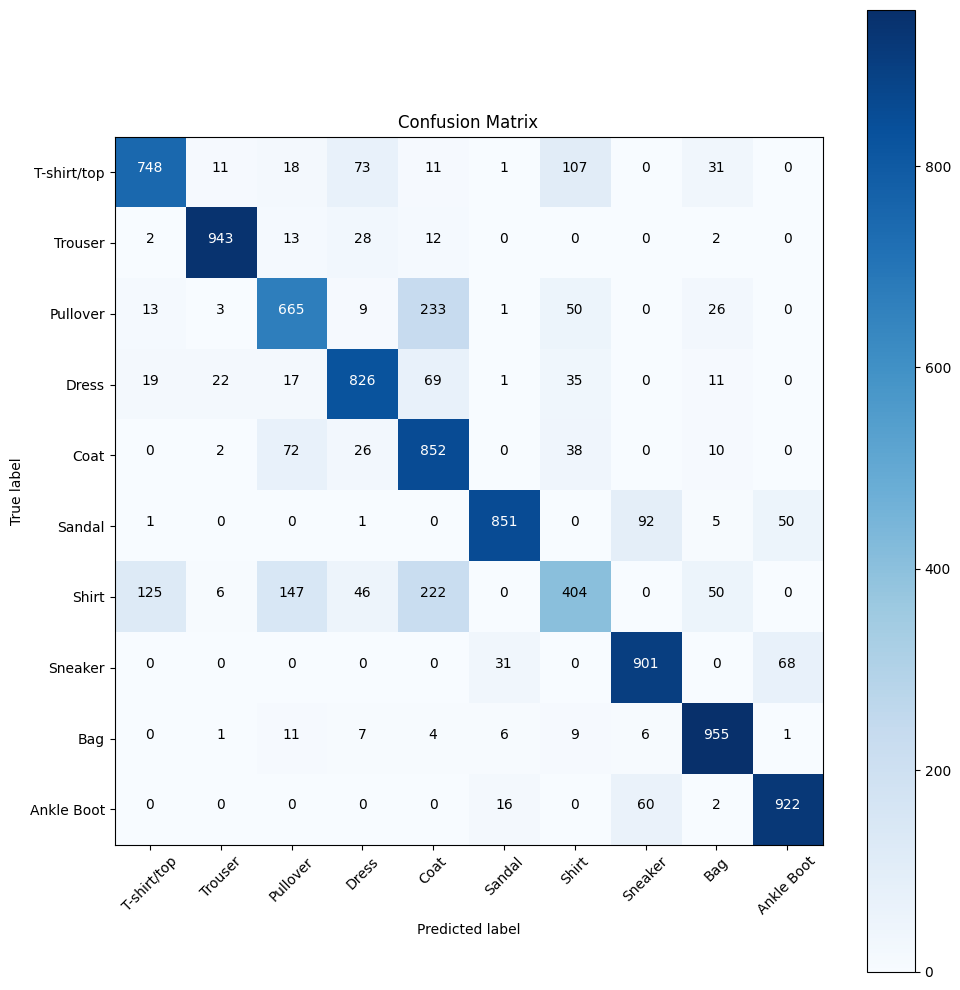

In [ ]:
# Ensure net, test_loader, and classes are defined and initialized before calling these functions
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
cm = compute_confusion_matrix(net, test_loader, classes)
plot_confusion_matrix(cm, classes)

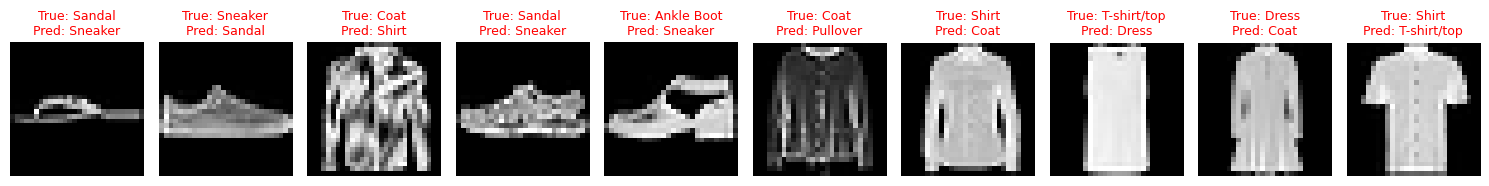

In [ ]:
def visualize_misclassified_examples_colored(net, test_loader, classes, num_images=10):
    """
    Visualizes a number of misclassified examples, with the true label in green and the predicted label in red.

    Parameters:
    - net: Trained neural network model.
    - test_loader: DataLoader for the test dataset.
    - classes: List of class names.
    - num_images: Number of misclassified images to display.
    """
    misclassified = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            misclassified += [(images[i], labels[i].item(), predicted[i].item()) for i in range(images.size(0)) if labels[i] != predicted[i]]
            if len(misclassified) >= num_images:
                break

    fig, axs = plt.subplots(1, num_images, figsize=(15, 4), squeeze=False)
    for i, (image, true_label, pred_label) in enumerate(misclassified[:num_images]):
        axs[0, i].imshow(image.squeeze().numpy(), cmap='gray')
        axs[0, i].set_title(f'True: {classes[true_label]}\nPred: {classes[pred_label]}', fontsize=9)
        # Apply colors to titles
        axs[0, i].title.set_color('red')
        axs[0, i].axis('off')
    plt.tight_layout()
    plt.show()

# Ensure net, test_loader, and classes are defined and initialized before calling this function
visualize_misclassified_examples_colored(net, test_loader, classes, num_images=10)


# TODO: Your turn!! How can we improve the model?

Here are some tips to modify the code to improve performance.

* **Architecture**
    * **Deeper Layers:**  Experiment by adding more linear layers to extract more complex features.
    * **Regularization:** Incorporate Dropout or L1/L2 weight regularization to combat overfitting.

* **Hyperparameters:**
    * **Learning Rate:**  Explore various learning rates and optimization algorithms (Adam, RMSprop, SGD with momentum, etc).
    * **Batch Size:** Tweak the batch size to influence gradient updates and convergence.

* **Training**
    * **Longer Training:** Increase the number of epochs (iterations over the dataset).
    * **Early Stopping:** Halt training if validation performance plateaus or worsens.

For convenience, I provided the core code below, no need to touch the code above.
I don't provide guidance on how to make the changes specifically on purpose. Use your method of choice: Google search, stackoverflow, Pytorch documentation, ChatGPT, Google Gemini, your own knowledge... If you're lost, you can copy paste the whole cell below and ask ChatGPT4: "implement all to dos: [the copy-pasted code]"



In [ ]:
BATCH_SIZE = 32 #TODO MODIFY BATCH SIZE

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()  # Initialize base class (nn.Module)

    self.flatten = nn.Flatten()  # Flattens multidimensional input into a single dimension

    self.linear_relu_stack = nn.Sequential(
      #TODO: ADD LAYERS AND/OR DROPOUT
      nn.Linear(28*28, 512),  # First linear layer (input: 28*28, output: 512)
      nn.ReLU(),               # ReLU activation (introduces non-linearity)
      nn.Linear(512, 10),      # Second linear layer (maps to 10 output classes)
    )

  def forward(self, x):
    x = self.flatten(x)            # Flatten the input image data
    logits = self.linear_relu_stack(x)  # Pass through linear layers and activation
    return logits                   # Raw output scores for each class


# Create an instance of our neural network model
net = NeuralNet()

# Define the loss function (cross-entropy is common for classification)
#TODO: ADD REGULARIZATION
criterion = nn.CrossEntropyLoss()

# Set up the optimizer (SGD with a learning rate of 0.001 and momentum)
#TODO: CHANGE THE OPTIMIZER OR HYPERPARAMETERS
optimizer = optim.Adam(net.parameters(), lr=0.001)

#TODO: CHANGE NUMBER OF EPOCHS
train_model(net, train_loader, eval_loader, optimizer, criterion, num_epoch = 6)

test_model(net, test_loader)

100%|██████████| 375/375 [00:01<00:00, 202.39it/s]


Epoch 1 Accuracy: 85.54166666666667%


100%|██████████| 375/375 [00:02<00:00, 183.20it/s]


Epoch 2 Accuracy: 86.36666666666666%


100%|██████████| 375/375 [00:01<00:00, 212.73it/s]


Epoch 3 Accuracy: 87.68333333333334%


100%|██████████| 375/375 [00:01<00:00, 209.26it/s]


Epoch 4 Accuracy: 85.625%


100%|██████████| 375/375 [00:01<00:00, 212.55it/s]


Epoch 5 Accuracy: 87.65833333333333%


100%|██████████| 375/375 [00:01<00:00, 215.67it/s]


Epoch 6 Accuracy: 88.1%
Accuracy of the network on the test images: 87.35 %


# Tutorial 2B: Introduction to Convolutional Neural Networks

When transitioning from implementing a Feedforward Neural Network (FNN) to a Convolutional Neural Network (CNN) in PyTorch, several key changes and concepts are introduced:

**Introduction of convolution layers**

In CNNs, we use convolutional layers (`torch.nn.Conv2d`) instead of fully connected layers as in FNNs. Convolutional layers apply a convolution operation to the input, capturing spatial hierarchies in the data. This makes CNNs particularly well-suited for processing images and other types of spatial data.

**Utilization of Pooling Layers**

Pooling layers (such as `torch.nn.MaxPool2d`) are used in CNNs to reduce the spatial dimensions of the output from the convolutional layers. Pooling helps in reducing the number of parameters, computation, and helps in achieving spatial invariance to some extent.

**Flattening the Output for Fully Connected Layers**

After several convolutional and pooling layers, the output is flattened (using `torch.flatten` or the `view` method) to feed into fully connected layers. This step is necessary to transition from the spatial representation of data to a format suitable for classification or regression.

**Adjusting to Input Shape Requirements**

CNNs require the input data to have a specific shape, typically `[batch_size, channels, height, width]`, meaning that preprocessing of data might be necessary to reshape inputs accordingly.

**Parameter Sharing and Local Connectivity**

Convolutional layers share parameters across different parts of the input, significantly reducing the model size compared to FNNs. This approach, combined with local connectivity (processing small, local areas of the input), allows CNNs to be more efficient and effective for image data.

**Increased Depth with Many Layers**

CNNs often utilize deeper architectures than FNNs because the convolutional and pooling layers allow for efficient processing of large inputs such as images. The depth of CNNs enables them to capture complex patterns with a hierarchical structure.

Let's see how to create a CNN class.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Input: 1x28x28, Output: 32x28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32x14x14

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Output: 64x14x14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64x7x7
        )

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64*7*7, 128),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(128, 10),      # Mapping to 10 output classes
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Nothing changes for the rest of the code!

In [ ]:
# Batch size, optimizers, and other hyperparameters remain as you defined them earlier.
BATCH_SIZE = 32

# Create an instance of our CNN model
net = CNN()

# Continue using CrossEntropyLoss for the classification
criterion = nn.CrossEntropyLoss()

# Using Adam optimizer with the CNN, including weight decay for regularization
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

# Adjusted number of epochs for training the CNN model
train_model(net, train_loader, eval_loader, optimizer, criterion, num_epoch=2)

test_model(net, test_loader)

100%|██████████| 750/750 [00:08<00:00, 91.76it/s]


Epoch 1 Accuracy: 85.76666666666667%


100%|██████████| 750/750 [00:09<00:00, 80.54it/s]


Epoch 2 Accuracy: 89.08333333333333%
Accuracy of the network on the 10000 test images: 89.79 %


### Did you remark training is much slower now? Time to move to GPUs!
Let's move our model to GPUs as follows:

In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Create an instance of your CNN model
net = CNN().to(device)  # Move model to the selected device

cpu


If it uses a GPU it should say "cuda". If not, go to Runtime > Change runtime type > T4 GPU. It will restart the session.
Some of your functions before will now break because they are not compatible with GPU runs. We will update the two most important ones: train and test.

**Why Change Runtime to T4 GPU?**

Google Colab provides various runtime types including none, CPU, and different GPU options. The T4 GPU is one of the GPU options offered by Google Colab for accelerating computational tasks. Switching the runtime to a T4 GPU (or any available GPU) is recommended for deep learning tasks because:

* Speed: GPUs can perform parallel operations on multiple data points simultaneously, making them significantly faster than CPUs for tasks like training neural networks, which involve a lot of matrix multiplications and additions.
* Efficiency: Training deep learning models on large datasets can be time-consuming and computationally expensive on CPUs. GPUs can reduce training time from days to hours or even minutes.

**Session Restart Requirement**

When you change the runtime type in Colab from CPU to GPU, the session restarts. This is because switching the hardware accelerator requires initializing a new virtual machine (VM) that provides the selected hardware. As a result, any data stored in the VM's memory or any specific configurations done in the previous session are lost and need to be redone or reloaded.

**Updating Functions for GPU Compatibility**

The move to GPU requires modifications to your code to ensure that the neural network model and the data it processes are moved to the GPU. This is because PyTorch tensors and models operate on the device they are located on, and operations between tensors (or tensors and models) need to occur on the same device. The specific line change involves moving tensors to the GPU, typically using .to('cuda') or .cuda() method, like so:

```inputs, labels = inputs.to('cuda'), labels.to('cuda')```

This change ensures that the data tensors are on the same device as the model before performing operations like forward passes or backpropagation. If this step is skipped, PyTorch will raise an error because it cannot perform operations between tensors on different devices (e.g., a model on a GPU trying to process data still on the CPU).

In [ ]:
def train_model(net, train_loader, eval_loader, optimizer, criterion, num_epoch = 2):
    """
    Trains a neural network model and evaluates on a test set after each epoch.

    Parameters:
    - net: The neural network to train.
    - train_loader: DataLoader for the training data.
    - test_loader: DataLoader for the evaluation data.
    - optimizer: Optimization algorithm.
    - criterion: Loss function.
    """
    for epoch in range(num_epoch):
        # Training Phase
        running_loss = 0.0
        for i, data in enumerate(tqdm(train_loader)):  # Iterate over mini-batches of data

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data  # Unpack the batch's input images and their labels


            ####### CHANGE FOR GPU USAGE #######
            inputs, labels = inputs.to(device), labels.to(device)
            ####################################

            # zero the parameter gradients
            optimizer.zero_grad()  # Reset accumulated gradients from previous steps

            # forward + backward + optimize
            outputs = net(inputs)  # Forward pass: Compute predictions
            loss = criterion(outputs, labels)  # Calculate the loss value
            loss.backward()  # Backpropagation: Compute gradients of the loss
            optimizer.step()  # Update model parameters based on the gradients

            running_loss += loss.item()  # Add loss of this mini-batch to running total

        # Evaluation Phase
        correct = 0
        total = 0
        with torch.no_grad():  # Disable gradient calculation during evaluation
            for data in tqdm(eval_loader):
                images, labels = data

                ####### CHANGE FOR GPU USAGE #######
                images, labels = images.to(device), labels.to(device)
                ####################################

                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1} Accuracy: {accuracy}%')

In [ ]:
def test_model(net, test_loader):
    """
    Tests a neural network model's performance on the test dataset.

    Parameters:
    - net: The neural network to test.
    - test_loader: DataLoader for the test data.
    """
    correct = 0  # Initialize a counter for correct predictions
    total = 0  # Initialize a counter for the total number of test images

    # Ensure the model is in evaluation mode
    net.eval()

    with torch.no_grad():  # Temporarily disable gradient calculation for evaluation
        for data in test_loader:
            images, labels = data  # Get a batch of test images and their labels

            ####### CHANGE FOR GPU USAGE #######
            images, labels = images.to(device), labels.to(device)
            ####################################

            outputs = net(images)  # Pass images through the network for predictions
            _, predicted = torch.max(outputs.data, 1)  # Get index of the highest probability class
            total += labels.size(0)  # Update the total image count
            correct += (predicted == labels).sum().item()  # Increment correct count if predictions match

    print(f'Accuracy of the network on the test images: {100 * correct / total} %')

In [ ]:
# Using Adam optimizer with the CNN, including weight decay for regularization
# It is very important to reinitialize the optimizer.
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

# Example Usage (Assuming you have your dataset/models set up)
train_model(net, train_loader, eval_loader, optimizer, criterion, num_epoch = 5)
test_model(net, test_loader)

100%|██████████| 500/500 [00:03<00:00, 163.51it/s]


Epoch 1 Accuracy: 84.78333333333333%


100%|██████████| 500/500 [00:04<00:00, 119.53it/s]


Epoch 2 Accuracy: 86.575%


100%|██████████| 500/500 [00:05<00:00, 94.51it/s]


Epoch 3 Accuracy: 87.33333333333333%


100%|██████████| 500/500 [00:04<00:00, 101.25it/s]


Epoch 4 Accuracy: 87.66666666666667%


100%|██████████| 500/500 [00:03<00:00, 159.21it/s]


Epoch 5 Accuracy: 87.95833333333333%
Accuracy of the network on the test images: 86.8 %
